## Below scripts helps to displays, F-PKI map server RTT comparison for 38 Significant Countries (According to ANOVA). 

#### This statistical tests results are based entirely on the sample data that we collected and analyzed when determining statistical significance or non-significance.

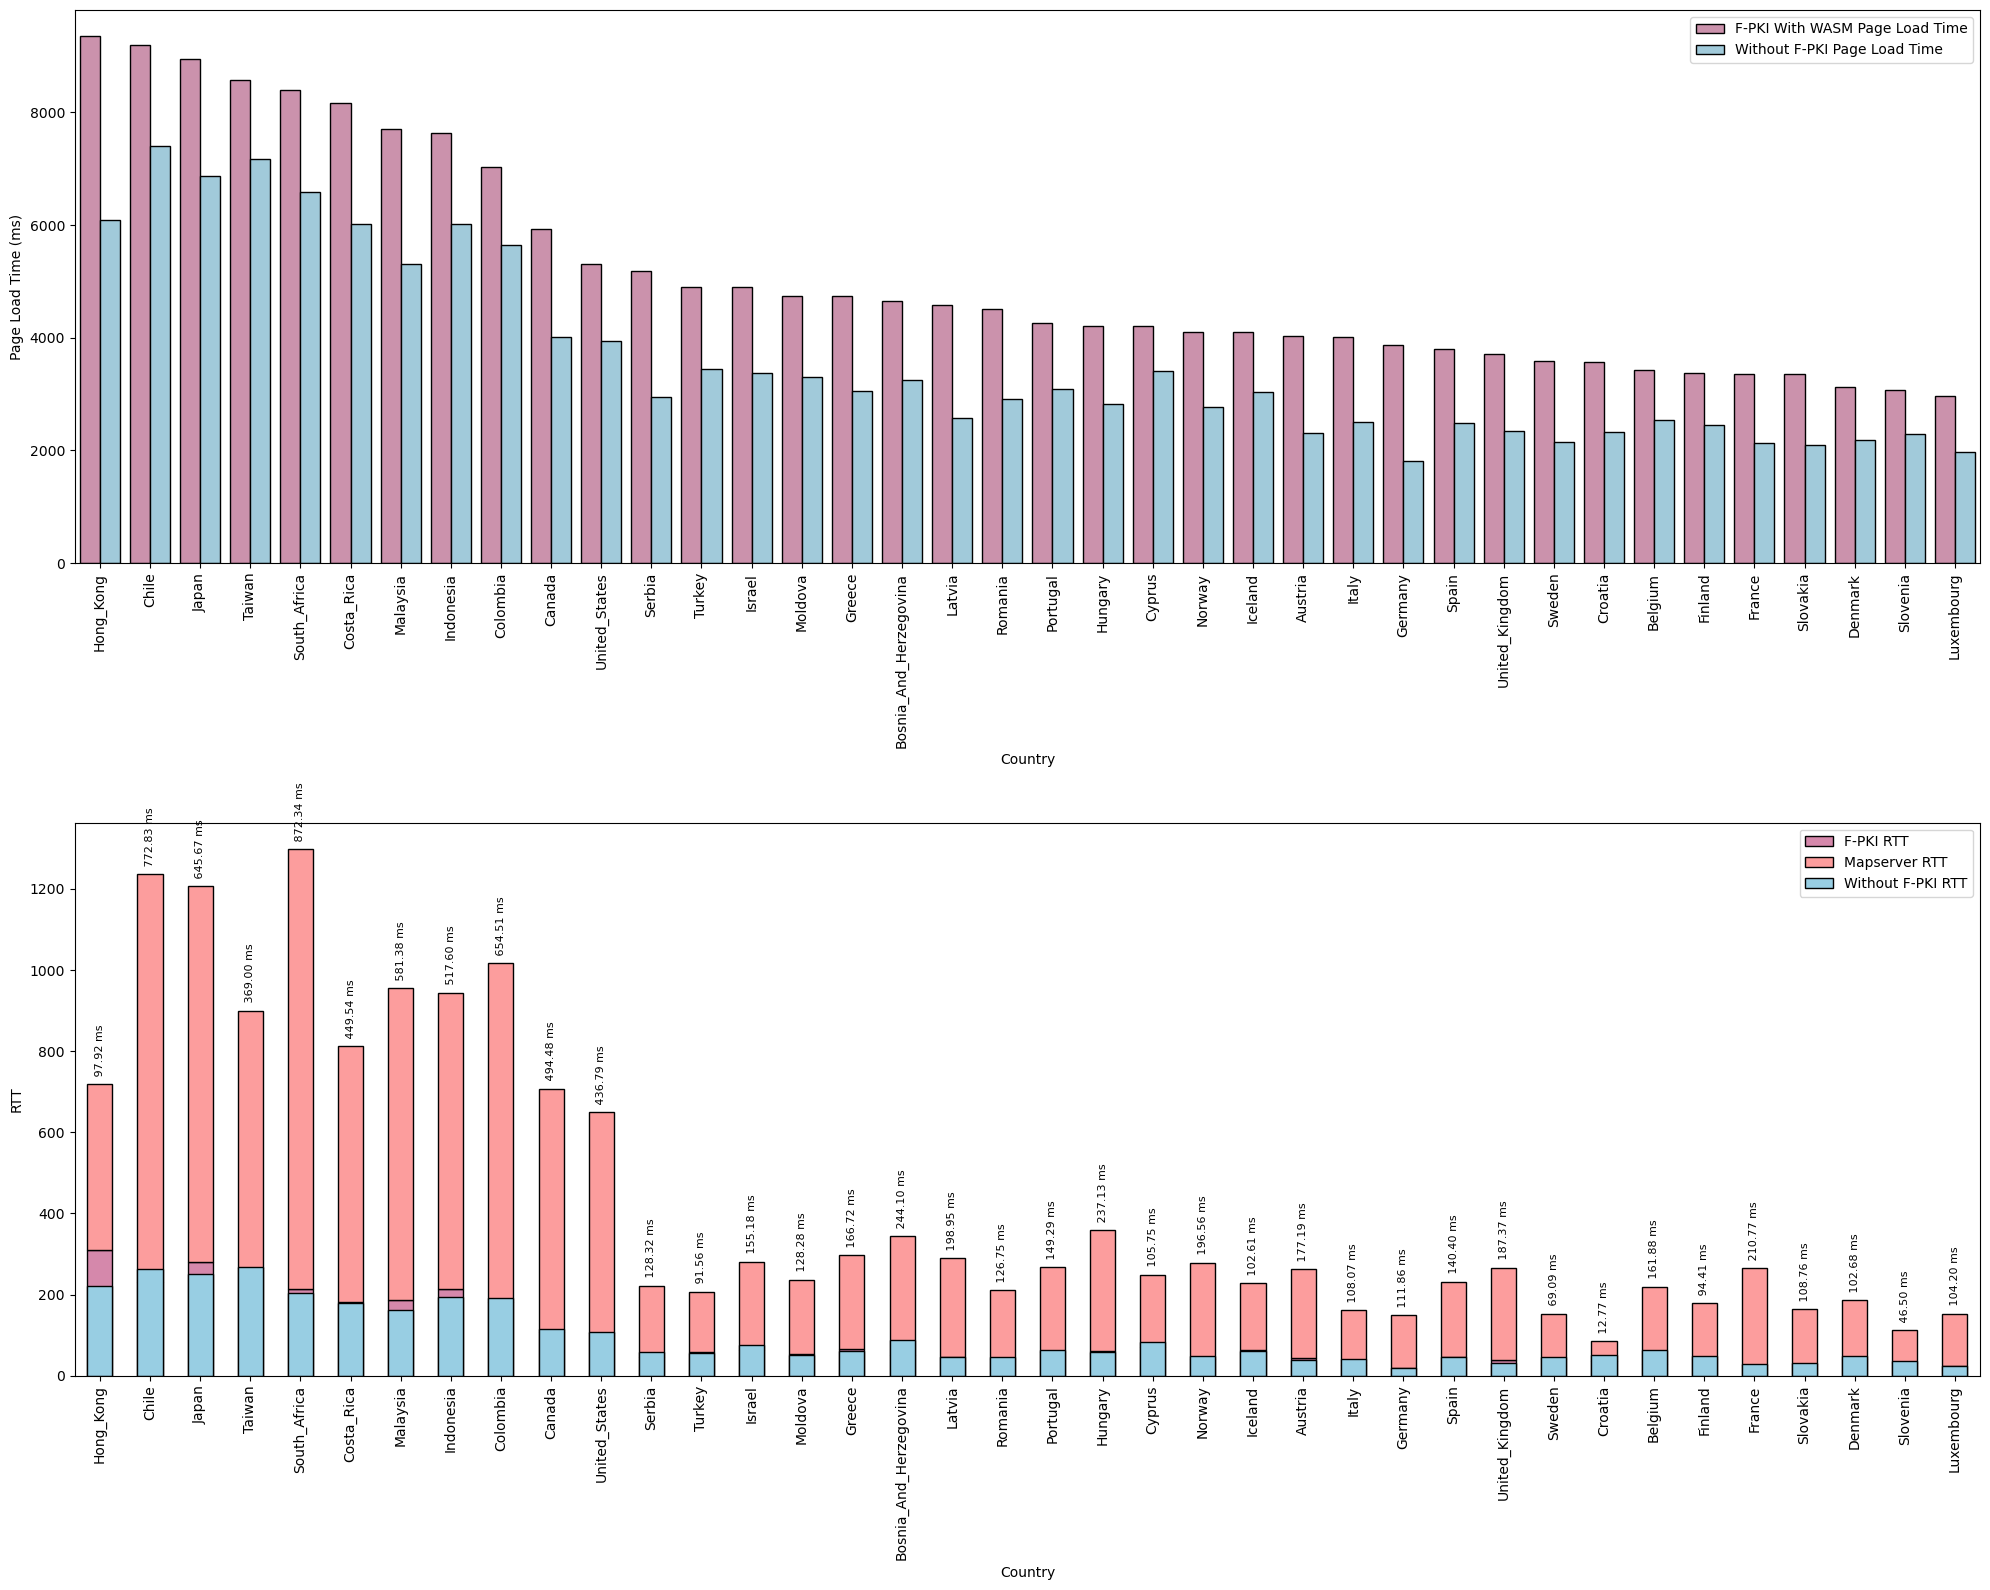

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

df1_cleaned = pd.read_csv('new_first_phase_anova_wasmrtt.csv')
df3_cleaned = pd.read_csv('new_third_phase_anova.csv')

df1_cleaned = df1_cleaned.dropna(subset=['Page Load Time_x'])
df3_cleaned = df3_cleaned.dropna(subset=['Page Load Time'])

df1_grouped = df1_cleaned.groupby('Country')['Page Load Time_x']
df3_grouped = df3_cleaned.groupby('Country')['Page Load Time']

countries = df1_cleaned['Country'].unique()

anova_results = {}
for country in countries:
    if country in df1_grouped.groups and country in df3_grouped.groups:
        fvalue, pvalue = stats.f_oneway(df1_grouped.get_group(country), df3_grouped.get_group(country))
        if pvalue < 0.05:
            anova_results[country] = {'F-value': fvalue, 'P-value': pvalue}
#             print(f"Country: {country}")
#             print(f"ANOVA F-value: {fvalue}")
#             print(f"ANOVA P-value: {pvalue}")
#             print("--------------------")

significant_countries = list(anova_results.keys())
significant_df = pd.DataFrame({'Country': significant_countries})
significant_df = significant_df.merge(df1_grouped.mean().reset_index(), left_on='Country', right_on='Country', suffixes=('_F-PKI', '_F-PKI With WASM'))
significant_df = significant_df.merge(df3_grouped.mean().reset_index(), left_on='Country', right_on='Country', suffixes=('_F-PKI', '_Without F-PKI With WASM'))
significant_df.rename(columns={'Page Load Time_x': 'Page Load Time_F-PKI', 'Page Load Time': 'Page Load Time_Without F-PKI With WASM'}, inplace=True)
significant_df = significant_df.sort_values(by='Page Load Time_F-PKI', ascending=False)
sorted_countries_order = significant_df['Country'].tolist()

melted_df = pd.melt(significant_df, id_vars='Country', value_vars=['Page Load Time_F-PKI', 'Page Load Time_Without F-PKI With WASM'])
melted_df[''] = ['F-PKI With WASM Page Load Time'] * len(significant_df) + ['Without F-PKI Page Load Time'] * len(significant_df)

colors = ['#D588AB', '#98CEE3']  

fig, axes = plt.subplots(2, 1, figsize=(20, 16), gridspec_kw={'height_ratios': [2, 2]})

sns.barplot(
    data=melted_df,
    x='Country',
    y='value',
    hue='',
    palette=colors,
    edgecolor='black',
    order=sorted_countries_order,  
    ax=axes[0]  
)

axes[0].set_xlabel('Country')
axes[0].set_ylabel('Page Load Time (ms)')
axes[0].tick_params(axis='x', rotation=90)

significant_countries_df1 = df1_cleaned[df1_cleaned['Country'].isin(significant_countries)]
significant_countries_df3 = df3_cleaned[df3_cleaned['Country'].isin(significant_countries)]
significant_countries_df1 = significant_countries_df1.dropna(subset=['WASM RTT'], how='all')

melted_rtt_df1 = pd.melt(significant_countries_df1, id_vars='Country', value_vars=['RTT_x', 'WASM RTT'])  
melted_rtt_df3 = pd.melt(significant_countries_df3, id_vars='Country', value_vars=['RTT'])
melted_rtt_df1['value'] = pd.to_numeric(melted_rtt_df1['value'], errors='coerce')  
melted_rtt_df3['value'] = pd.to_numeric(melted_rtt_df3['value'], errors='coerce') 
melted_rtt_df1 = melted_rtt_df1.dropna(subset=['value'])
melted_rtt_df3 = melted_rtt_df3.dropna(subset=['value'])

pivoted_rtt_df1 = melted_rtt_df1.pivot_table(values='value', index='Country', columns='variable')
pivoted_rtt_df3 = melted_rtt_df3.pivot_table(values='value', index='Country', columns='variable')
pivoted_rtt_df1.fillna(0, inplace=True)
pivoted_rtt_df3.fillna(0, inplace=True)
pivoted_rtt_df1 = pivoted_rtt_df1.reindex(sorted_countries_order)
pivoted_rtt_df3 = pivoted_rtt_df3.reindex(sorted_countries_order)

mean_diff = pivoted_rtt_df1['RTT_x'] - pivoted_rtt_df1['WASM RTT']

ax = pivoted_rtt_df1.plot(kind='bar', stacked=True, ax=axes[1], color=['#D588AB', '#fc9d9d'], edgecolor='black')
pivoted_rtt_df3.plot(kind='bar', stacked=True, ax=axes[1], color=['#98CEE3'], edgecolor='black')
bar_heights = [p.get_height() for p in ax.patches]
max_bar_height = max(bar_heights)


for p, mean_val in zip(ax.patches[len(pivoted_rtt_df1):], mean_diff):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    
    new_y = y + height + 0.01 * max_bar_height  
    
    ax.annotate(f' {-mean_val:.2f} ms', (x + width / 2, new_y), ha='center', va='bottom', rotation='vertical', fontsize=8)

axes[1].set_xlabel('Country')
axes[1].set_ylabel('RTT')
axes[1].legend(labels=['F-PKI RTT', 'Mapserver RTT', 'Without F-PKI RTT'])  
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
#plt.savefig("rq3countryrtt.png", dpi=300, bbox_inches='tight') 
plt.show()


### User extra waiting Time  $\small{=}$  F-PKI map server RTT $\small{-}$ F-PKI  web server RTT 
###                                         $\small{=}$  Hong Kong F-PKI map server RTT is 408.52 ms $\small{-}$ Hong Kong F-PKI  web server RTT is 310.59 ms 
###                                          $\small{=}$   97.92 ms